In [ ]:
from dataclasses import dataclass
from typing import Final

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import PPoly

from fin_equation_analysis.fin.fin import Fin

In [ ]:
def plot_results(
    fig: plt.Figure,
    sol: tuple[[PPoly] * 6],
    x: np.ndarray,
    label: str,
) -> None:
    T, dT, V, Ac, dAc, P = sol
    axs = fig.axes
    axs[0].plot(x, P, label=label)
    axs[0].set_ylabel(r"$P$ [mm]")

    axs[1].plot(x, V, label=label)
    axs[1].set_ylabel(r"$V{(x)}$ [mm$^3$]")

    axs[2].plot(x, Ac, label=label)
    axs[2].set_ylabel(r"$A_c{(x)}$ [mm$^2$]")

    axs[3].plot(x, dAc, label=label)
    axs[3].set_ylabel(r"$A'_c{(x)}$ [mm]")

    axs[4].plot(x, T_inf + T, label=label)
    axs[4].set_ylabel(r"$T{(x)}$ [K]")

    axs[5].plot(x, dT, label=label)
    axs[5].set_ylabel(r"$T'{(x)}$ [K / mm]")

    axs[6].plot(x, -k * dT, label=label)
    axs[6].set_ylabel(r"$q''_x = -k T'{(x)}$ [W / mm$^2$]")

    axs[7].plot(x, -k * Ac * dT, label=label)
    axs[7].set_ylabel(r"$q_x = -k A_c T'{(x)}$ [W]")

In [ ]:
k: Final[int] = 5e-3  # W mm-1 K-1
h: Final[int] = 200e-6  # W mm-2 K-1
r: Final[float] = 3e1  # mm
L: Final[float] = 1e2  # mm
T_b: Final[int] = 398  # K
T_inf: Final[int] = 298  # K

In [ ]:
@dataclass
class CircularUniformPinFin(Fin):
    r0: int | float

    def dP_dx(self, x: np.ndarray) -> np.ndarray:
        return np.zeros_like(x)

    def d2Ac_dx2(self, x: np.ndarray) -> np.ndarray:
        return np.zeros_like(x)

In [ ]:
@dataclass
class CircularLinearPinFin(Fin):
    r0: int | float

    def dP_dx(self, x: np.ndarray) -> np.ndarray:
        return np.full_like(x, -2 * np.pi * self.r0 / self.L)

    def d2Ac_dx2(self, x: np.ndarray) -> np.ndarray:
        return np.full_like(x, 2 * np.pi * self.r0**2 / L**2)

The general fin equation is given by

$$
\frac{d^2 \theta}{dx^2}
+ \left( \frac{1}{A_c} \frac{d A_c}{dx} \right) \frac{d \theta}{dx}
- \frac{h P}{k A_c} \theta
= 0
$$
where $\theta{(x)} \equiv T{(x)} - T_{\infty}$.

In state-space form,
\begin{gathered}
    \begin{align*}
        y_0 &= \theta{(x)} & y_1 &= \theta'{(x)} = \frac{d \theta}{dx} \\
        y_2 &= V{(x)} = \int_0^x A_c\,dx & y_3 &= A_c{(x)} \\
        y_4 &= A_c'{(x)} = \frac{d A_c}{dx} & y_5 &= P{(x)} \\
    \end{align*}\\
    \begin{equation*}
        \frac{d \textbf{y}}{dx}
        = \begin{bmatrix} y'_0 \\ y'_1  \\ y'_2 \\ y'_3 \\ y'_4 \\ y'_5 \end{bmatrix}
        = \begin{bmatrix} \theta' \\ \theta'' \\ A_c \\ A'_c \\ A''_c \\ P' \end{bmatrix}
        = \begin{bmatrix}
            y_1 \\
            - \frac{y_4}{y_3} y_1 + \frac{h y_5}{k y_3} y_0 \\
            y_3 \\
            y_4 \\
            \cdots \\
            \cdots
        \end{bmatrix}
    \end{equation*}
\end{gathered}

In [ ]:
def bc_uniform(ya, yb):
    return np.array(
        [
            # Temperature BCs
            ya[0] - (T_b - T_inf),  # θ(0) = T_b - T_inf
            yb[1],  # θ(L) = 0; adiabatic tip
            # Geometry BCs
            ya[2],
            ya[3] - np.pi * r**2,  # Ac(0) = πr²
            yb[3] - np.pi * r**2,  # Ac(L) = πr²
            ya[5] - 2 * np.pi * r,  # P(0) = 2πr
        ]
    )

In [ ]:
def bc_linear(ya, yb):
    return np.array(
        [
            # Temperature BCs
            ya[0] - (T_b - T_inf),  # θ(0) = T_b - T_inf
            yb[1],  # θ(L) = 0; adiabatic tip
            # Geometry BCs
            ya[2],  # V(0) = 0
            ya[3] - np.pi * r**2,  # Ac(0) = πr²
            yb[3] - 1e-13,  # Ac(L) = 0; reduces to a point
            ya[5] - 2 * np.pi * r,  # P(0) = 2πr
        ]
    )

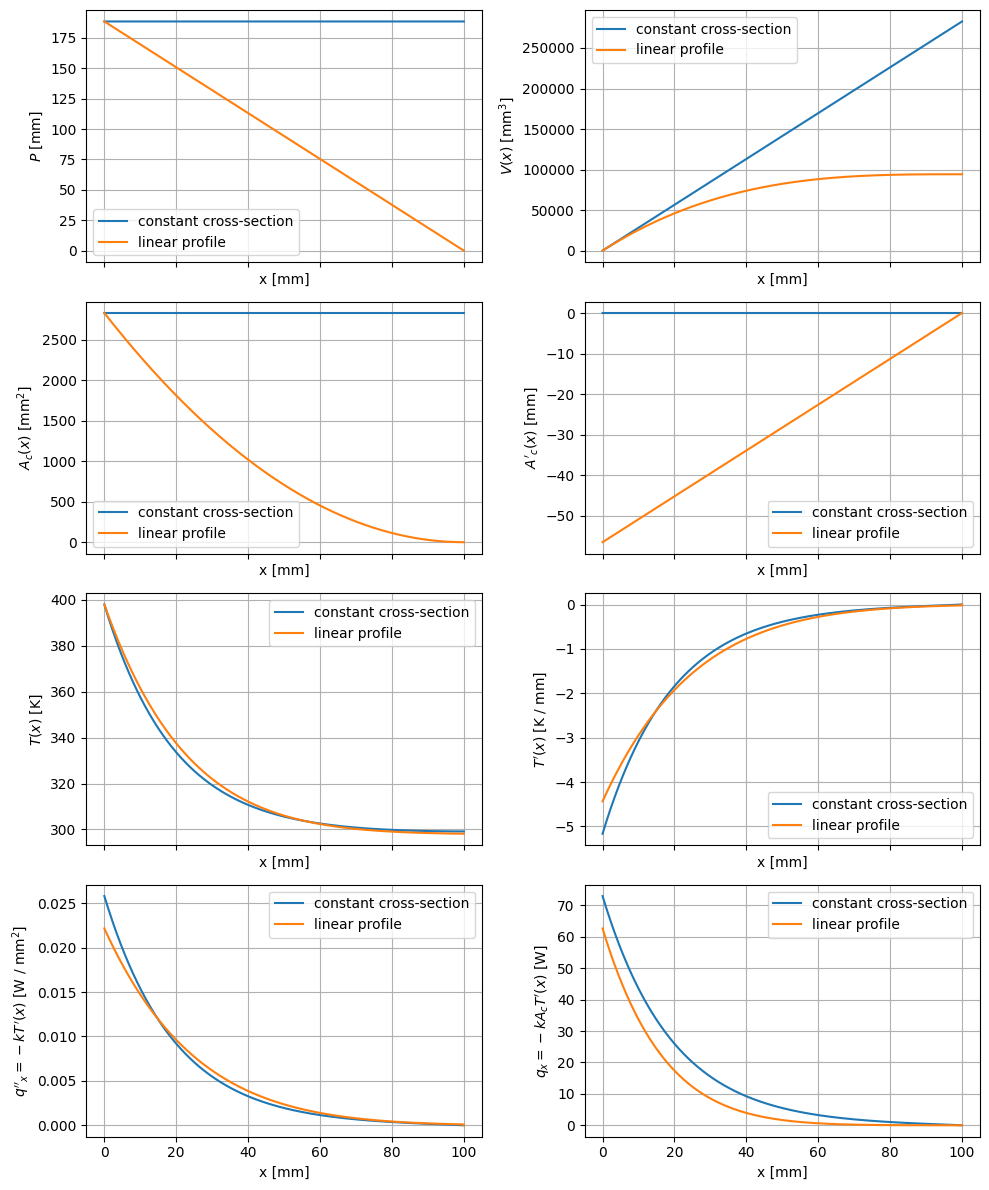

In [ ]:
x_plot = np.linspace(0, L, 100001)
sol_uniform = CircularUniformPinFin(k, h, L, T_b, T_inf, r).solve(bc_uniform)(x_plot)
sol_linear = CircularLinearPinFin(k, h, L, T_b, T_inf, r).solve(bc_linear)(x_plot)

fig, axs = plt.subplots(num=1, figsize=(10, 12), nrows=4, ncols=2, sharex="all")
plot_results(fig, sol_uniform, x_plot, "constant cross-section")
plot_results(fig, sol_linear, x_plot, "linear profile")

for ax in fig.axes:
    ax.set_xlabel(r"x [mm]")
    ax.grid(True)
    ax.legend()
plt.tight_layout()

In [ ]:
T_uniform, dT_uniform, V_uniform, Ac_uniform, dAc_uniform, P_uniform = sol_uniform
T_linear, dT_linear, V_linear, Ac_linear, dAc_linear, P_linear = sol_linear
q_uniform = (-k * Ac_uniform * dT_uniform)[5]
q_linear = (-k * Ac_linear * dT_linear)[5]
f"{q_uniform = }", f"{q_linear = }"

('q_uniform = 72.98038573506444', 'q_linear = 62.66763844521204')

In [ ]:
n_uniform = q_uniform / (h * 2 * np.pi * r * L * (T_b - T_inf))
n_linear = q_linear / (h * np.pi * r * np.sqrt(L**2 + r**2) * (T_b - T_inf))
f"{n_uniform = }", f"{n_linear = }"

('n_uniform = 0.19358648564147923', 'n_linear = 0.3184409838906148')

In [ ]:
M = np.sqrt(h * (2 * np.pi * r) * k * (np.pi * r**2)) * (T_b - T_inf)
m = np.sqrt((2 * h) / (k * r))
M, m, m * L

(73.00401616752501, 0.051639777949432225, 5.163977794943222)